In [39]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Feb  1 11:44:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    39W / 250W |   5677MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Libraries

In [40]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.81 s (started: 2022-02-01 11:44:08 +00:00)


In [41]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
time: 2.54 ms (started: 2022-02-01 11:44:11 +00:00)


In [42]:
!pip install --quiet optuna

time: 2.79 s (started: 2022-02-01 11:44:11 +00:00)


In [43]:
import os
import pandas as pd
import numpy as np
import time
import datetime
import itertools
import glob
import re
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')

from skimage import io

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import backend as K

import optuna # hyeperparam optimization 

time: 20 ms (started: 2022-02-01 11:44:14 +00:00)


# Variables

## Paths

In [44]:
root_dir ='/content/drive/MyDrive/@Projet datascientest/'
raw_data_dir = root_dir + 'RAW DATA/'
DL_dir = root_dir + 'DEEP LEARNING/' 

# export dir with time satmp
timestamp = datetime.datetime.now().strftime('%y%m%d_%HH%M')
export_dir = DL_dir + timestamp + '/'
os.makedirs(export_dir)
print(str(export_dir))

/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/220201_11H44/
time: 8.04 ms (started: 2022-02-01 11:44:14 +00:00)


## Other

In [45]:
# seed
random_seed = 42

# resolution des images apres redimmensionnement (/!\ inversé par rapport à scikit)
resol = (240, 320) # (240, 320), [(24 , 32),(48 , 64),(72 , 96)]
# number of class to keep 
family_number = 7 # 7 pour comparaison Xgboost (acc = 0.32) & random 1/7 = 0.14
number_of_images = 5000 # None to get all images 
add_FRUIT360_images = False #add a class with 6000 images of 131 classes of fruit if true (kaggle dataset - 45 random images/class)


# epoch
epochs = 10
# learing rate 
# learning_rate = 0.001 # a learning rate of 0.001 is often used / working
# batch size 
batch_size = 32 #32
# base model trainable 
base_model_trainable = False

# number of trials optuna
n_trials = 25 

#ZIP file with images 
raw_data_folder = 'RAW DATA.zip'
# raw_data_folder = 'RAW DATA FOR DEBUG.zip' # pour aller plus vite sur unzip 1400 images only 
# df with file_path 
csv_file_paths = 'image_and_json_data_DEBUG.csv' if raw_data_folder == 'RAW DATA FOR DEBUG.zip' else 'image_and_json_data.csv'

# DEBUG 
debug = False
one_image_per_class_only = False  # HARD DEBUG TO SEE if CNN learn
# epochs
number_of_images = 1000 if debug else number_of_images
epochs = 2 if debug else epochs
family_number = 3 if debug else family_number 


time: 13.7 ms (started: 2022-02-01 11:44:14 +00:00)


# Load & filter data

## Unzip images

In [46]:
# unzipping the file into the VM disk is SO much faster than reading each file individually from Drive
# cf https://stackoverflow.com/questions/59120853/google-colab-is-so-slow-while-reading-images-from-google-drive
main_path = "/content/"  + raw_data_folder.replace('.zip','') 
if os.path.exists(main_path)== False :
  if csv_file_paths == 'image_and_json_data_DEBUG.csv':
    !unzip '/content/drive/MyDrive/@Projet datascientest/RAW DATA FOR DEBUG.zip' -d "/content"
  elif csv_file_paths == 'image_and_json_data.csv':
    !unzip '/content/drive/MyDrive/@Projet datascientest/RAW DATA.zip' -d "/content"
else:
  print('ZIP already extracted')

ZIP already extracted
time: 2.45 ms (started: 2022-02-01 11:44:14 +00:00)


In [47]:
#FRUIT360 dataset pour créer un dataset sans champigons 
main_path = "/content/FRUIT360"
if os.path.exists(main_path)== False :
  if add_FRUIT360_images:
    !unzip '/content/drive/MyDrive/@Projet datascientest/FRUIT360.zip' -d "/content"

time: 1.57 ms (started: 2022-02-01 11:44:14 +00:00)


## File_path df

In [48]:
# df with path & target 
df_paths = pd.read_csv(root_dir + csv_file_paths)
print('{} rows in the file'.format(len(df_paths)))
df_paths .head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6,9,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


215410 rows in the file


,file_name,file_path,resolution,file_year,image_id,format,observation,label,image_url,user,date,thumbnail,location,gbif_info.kingdom,gbif_info.family,gbif_info.speciesKey,gbif_info.rank,gbif_info.phylum,gbif_info.orderKey,gbif_info.species,gbif_info.confidence,gbif_info.classKey,gbif_info.matchType,gbif_info.familyKey,gbif_info.status,gbif_info.usageKey,gbif_info.kingdomKey,gbif_info.genusKey,gbif_info.canonicalName,gbif_info.phylumKey,gbif_info.class,gbif_info.synonym,gbif_info.scientificName,gbif_info.genus,gbif_info.order,gbif_info.note,gbif_info,json_file
0,1208.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(243, 320)",2006,1208,jpg,1007,Agaricales,http://mushroomobserver.org/images/320/1208,25,2006-11-20 05:11:15,1,25,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
1,1604.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(320, 164)",2006,1604,jpg,1535,Agaricales,http://mushroomobserver.org/images/320/1604,43,2006-12-16 00:59:32,1,9,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
2,1608.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(320, 286)",2006,1608,jpg,1537,Agaricales,http://mushroomobserver.org/images/320/1608,43,2006-12-16 01:25:12,1,55,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
3,29.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(240, 320)",2006,29,jpg,23,Agaricales,http://mushroomobserver.org/images/320/29,1,2006-05-21 07:17:47,1,61,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
4,680.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(240, 320)",2006,680,jpg,536,Agaricus,http://mushroomobserver.org/images/320/680,1,2006-05-21 07:34:55,1,1859,Fungi,Agaricaceae,NaN,GENUS,Basidiomycota,1499.0,NaN,92.0,186.0,EXACT,4170.0,ACCEPTED,7893259.0,5.0,7893259.0,Agaricus,34.0,Agaricomycetes,False,Agaricus,Agaricus,Agaricales,NaN,NaN,observations_0.json


time: 1.66 s (started: 2022-02-01 11:44:14 +00:00)


In [49]:
# FRUIT360
if add_FRUIT360_images:
  # Trouver tous les chemins vers les fichiers qui finissent par .jpg
  liste = glob.glob('/content/FRUIT360/*/*.jpg')
  # Remplacer les \\ par /
  liste = list(map(lambda x : [x, x.split('/')[2]], liste))
  # Créer un DataFrame pandas
  df_FRUIT360  = pd.DataFrame(liste, columns=['drive_file_path', 'gbif_info.family'])
  display(df_FRUIT360.head())

time: 4.64 ms (started: 2022-02-01 11:44:16 +00:00)


In [50]:
# adjust paths for drive 
# SPECIFIC DRIVE lo laod image from content 
df_paths['drive_file_path'] =df_paths['file_path'].apply(lambda x: x.replace('C:/Users/thibe/Google Drive/@Projet datascientest',
                                              '/content')).apply(lambda x: x.replace('C:/Users/thibe/Google Drive/Projet datascientest',
                                              '/content')) # pas propre, remplacer par regex + re à l'occas 
df_paths['drive_file_path'] =df_paths['drive_file_path'].apply(lambda x: x.replace('\\','/'))
df_paths['drive_file_path']

0         /content/RAW DATA/IMAGES/2006/Agaricales/1208.jpg
1         /content/RAW DATA/IMAGES/2006/Agaricales/1604.jpg
2         /content/RAW DATA/IMAGES/2006/Agaricales/1608.jpg
3           /content/RAW DATA/IMAGES/2006/Agaricales/29.jpg
4            /content/RAW DATA/IMAGES/2006/Agaricus/680.jpg
                                ...                        
215405    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215406    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215407    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215408    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215409    /content/RAW DATA/IMAGES/2016/Zygomycota/59276...
Name: drive_file_path, Length: 215410, dtype: object

time: 409 ms (started: 2022-02-01 11:44:16 +00:00)


In [51]:
#select only 320,240 images with family info
df_paths = df_paths[df_paths['resolution']=='(320, 240)'] 

time: 158 ms (started: 2022-02-01 11:44:16 +00:00)


In [52]:
# drop na 
df_paths = df_paths[df_paths['gbif_info.family'].notna()]

time: 47.7 ms (started: 2022-02-01 11:44:16 +00:00)


In [53]:
# keep conf level over 90 
df_paths = df_paths.loc[df_paths['gbif_info.confidence']>90]

time: 45.8 ms (started: 2022-02-01 11:44:16 +00:00)


In [54]:
# keep only most common class
top_class = df_paths['gbif_info.class'].value_counts().index[0]
df_paths = df_paths[df_paths['gbif_info.class'] == top_class]
df_paths['gbif_info.class'].value_counts()

Agaricomycetes    74497
Name: gbif_info.class, dtype: int64

time: 84.6 ms (started: 2022-02-01 11:44:16 +00:00)


In [55]:
# Check number of classes 
pd.DataFrame(df_paths.groupby(['gbif_info.family'], as_index=False).size())

,gbif_info.family,size
0,Agaricaceae,5254
1,Albatrellaceae,204
2,Amanitaceae,4769
3,Amylocorticiaceae,16
4,Amylostereaceae,6
...,...,...
99,Tubariaceae,217
100,Tulasnellaceae,37
101,Tulostomataceae,2
102,Typhulaceae,44


time: 19.5 ms (started: 2022-02-01 11:44:16 +00:00)


In [56]:
# keep only top families 
top_fam = df_paths['gbif_info.family'].value_counts().index[:family_number].values
df_paths = df_paths[df_paths['gbif_info.family'].isin(top_fam)]

time: 27.7 ms (started: 2022-02-01 11:44:16 +00:00)


In [57]:
# ######### DEBUG LAST 3 FAMILLES TUOMR POUR INCLURE NO TUMOR ############
# # keep only top families 
# top_fam = df_paths['gbif_info.family'].value_counts().index.values[-3:]
# df_paths = df_paths[df_paths['gbif_info.family'].isin(top_fam)]
# #############################################

time: 703 µs (started: 2022-02-01 11:44:16 +00:00)


In [58]:
# reduce number or images if needed 
if number_of_images != None and not one_image_per_class_only: 
  df_paths,_ = train_test_split(df_paths,train_size=number_of_images,stratify=df_paths['gbif_info.family'],random_state=random_seed )
  print('{} rows in the file'.format(len(df_paths)))

5000 rows in the file
time: 66.8 ms (started: 2022-02-01 11:44:16 +00:00)


In [59]:
summary = df_paths.copy() #copy for later 
# summary.info()

time: 3.45 ms (started: 2022-02-01 11:44:17 +00:00)


In [60]:
# subset col of interest + label encoding
df = df_paths[['drive_file_path','gbif_info.family']].copy()
df['label'] = df['gbif_info.family'].replace(df['gbif_info.family'].unique(), [*range(len(df['gbif_info.family'].unique()))]).astype(str) # label encoding 

df.head()

,drive_file_path,gbif_info.family,label
44369,/content/RAW DATA/IMAGES/2010/Russula vinacea/...,Russulaceae,0
172598,/content/RAW DATA/IMAGES/2015/Lactarius delici...,Russulaceae,0
184582,/content/RAW DATA/IMAGES/2015/Tylopilus felleu...,Boletaceae,1
211179,/content/RAW DATA/IMAGES/2016/Russula parazure...,Russulaceae,0
63243,/content/RAW DATA/IMAGES/2011/Psilocybe cyanes...,Strophariaceae,2


time: 47.7 ms (started: 2022-02-01 11:44:17 +00:00)


In [61]:
# concat with FRUIT360 
if add_FRUIT360_images:
  df_FRUIT360['label'] = df['label'].max() + 1 
  df = pd.concat([df,df_FRUIT360]).reset_index(drop=True)

time: 1.85 ms (started: 2022-02-01 11:44:17 +00:00)


In [62]:
# compute number of classes
print('number of rows = {}'.format(len(df['label'])))
dict_label_df = pd.DataFrame(df.groupby(['label','gbif_info.family'], as_index=False).size())
classes_count = len(dict_label_df)
dict_label_df

number of rows = 5000


,label,gbif_info.family,size
0,0,Russulaceae,855
1,1,Boletaceae,847
2,2,Strophariaceae,628
3,3,Tricholomataceae,694
4,4,Amanitaceae,666
5,5,Agaricaceae,734
6,6,Cortinariaceae,576


time: 20.3 ms (started: 2022-02-01 11:44:17 +00:00)


In [63]:
# CREATE DICT LABELS 
dict_label = dict(dict_label_df[['label','gbif_info.family']].values)
dict_label

{'0': 'Russulaceae',
 '1': 'Boletaceae',
 '2': 'Strophariaceae',
 '3': 'Tricholomataceae',
 '4': 'Amanitaceae',
 '5': 'Agaricaceae',
 '6': 'Cortinariaceae'}

time: 6.57 ms (started: 2022-02-01 11:44:17 +00:00)


## Train/test split

In [64]:
#train/test 
df_train, df_test= train_test_split(df, train_size=0.8, stratify =df['label'], random_state=random_seed)
print(df_train.shape,df_test.shape)

(4000, 3) (1000, 3)
time: 14.1 ms (started: 2022-02-01 11:44:17 +00:00)


In [65]:
# compute a class weigts dict for unbalanced loss computation
# { cf https://qastack.fr/datascience/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras}
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes =np.unique(df_train['label']),y =df_train['label'])
class_weights = dict(enumerate(class_weights))

time: 5.72 ms (started: 2022-02-01 11:44:17 +00:00)


### Plot few images

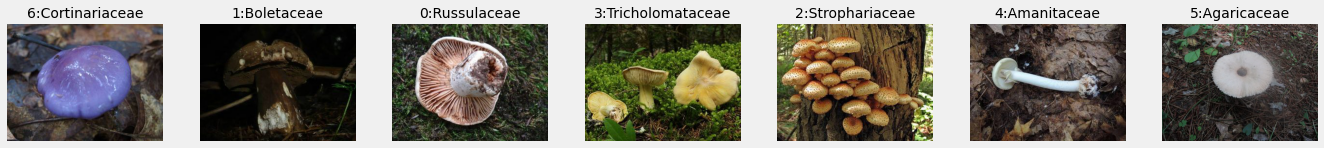

time: 415 ms (started: 2022-02-01 11:44:17 +00:00)


In [66]:
# first od each cat to check train/test
im_to_plot = df_train.groupby('label').head(1)
# plot
fig = plt.figure(figsize=(3*family_number,2))
j = 1 
for idx in im_to_plot.index:
  col_number = family_number
  row_number = 1
  ax = plt.subplot(row_number,col_number,j)
  im = io.imread(im_to_plot.loc[idx,'drive_file_path'])
  plt.imshow(im)
  label = str(im_to_plot.loc[idx,'label']) + ':' + dict_label[str(im_to_plot.loc[idx,'label'])]
  plt.title(label,size = 14)
  plt.axis('off')
  j +=1
fig.savefig(export_dir + str(resol) + '_first image of each family.jpeg' );

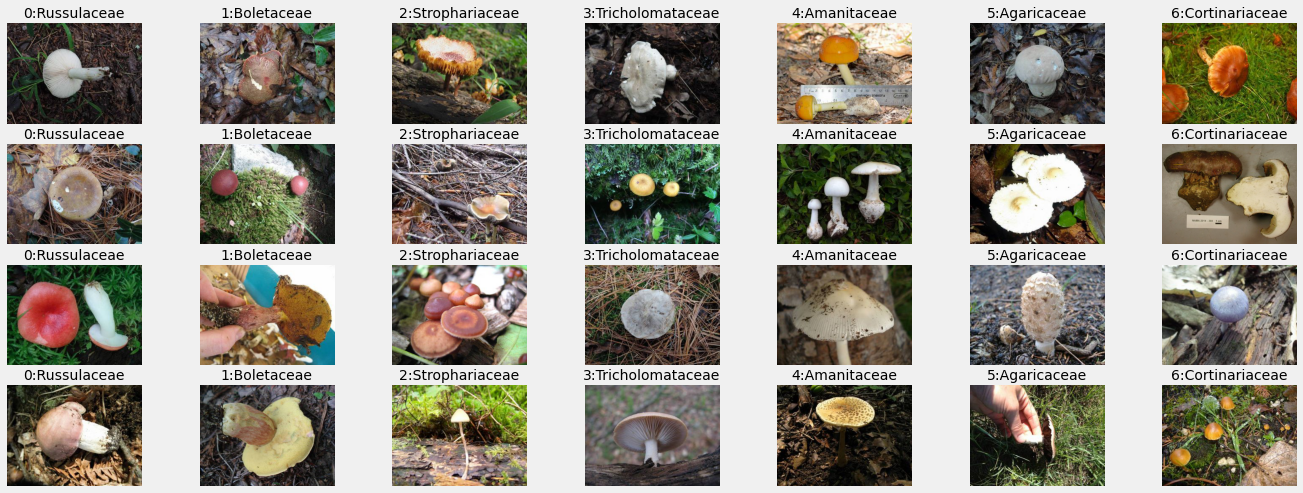

time: 2.16 s (started: 2022-02-01 11:44:17 +00:00)


In [67]:
# Plot random images de X_train (im_per_class per class)
im_per_class = 5 
#generate df with n image per class train set 
dfs_ = []
for n in range(im_per_class-1):
  df_ = df_train.groupby('label').apply(lambda x: x.sample(1))
  df_ = df_.droplevel(level=0)
  dfs_.append(df_)
im_to_plot = pd.concat(dfs_)
# plot
fig = plt.figure(figsize=(3*family_number,2*im_per_class))
j = 1 
for idx in im_to_plot.index:
  col_number = family_number
  row_number = im_per_class
  ax = plt.subplot(row_number,col_number,j)
  im = io.imread(im_to_plot.loc[idx,'drive_file_path'])
  plt.imshow(im)
  label = str(im_to_plot.loc[idx,'label']) + ':' + dict_label[str(im_to_plot.loc[idx,'label'])]
  plt.title(label,size = 14)
  plt.axis('off')
  j +=1
fig.savefig(export_dir + str(resol) + '_family examples.jpeg' );

# Tensorflow

## Data generator

In [68]:
# train 
train_data_generator = ImageDataGenerator(
                                            # rotation_range=90,
                                            # width_shift_range=0.2,
                                            # height_shift_range=0.2,
                                            # shear_range=0.2,
                                            # zoom_range=0.2,
                                            # horizontal_flip=True,
                                            # vertical_flip=True,
                                            # fill_mode='nearest',
                                          ) 

train_generator = train_data_generator.flow_from_dataframe(dataframe = df_train, 
                                                           x_col = "drive_file_path",y_col="label", 
                                                           target_size=resol,
                                                           batch_size=batch_size, 
                                                           class_mode='sparse')


Found 4000 validated image filenames belonging to 7 classes.
time: 67.2 ms (started: 2022-02-01 11:44:19 +00:00)


In [69]:
#test 
test_data_generator = ImageDataGenerator()
test_generator = test_data_generator.flow_from_dataframe(dataframe = df_test,
                                                         x_col = "drive_file_path",y_col="label", 
                                                           target_size=resol,
                                                           batch_size=batch_size, 
                                                           class_mode='sparse')


Found 1000 validated image filenames belonging to 7 classes.
time: 23.2 ms (started: 2022-02-01 11:44:19 +00:00)


## Callbacks

In [70]:
early_stopping = EarlyStopping(
                                patience=5, # Attendre 5 epochs avant application
                                min_delta = 0.01, # si au bout de 5 epochs la fonction de perte ne varie pas de 1%, 
                                 # que ce soit à la hausse ou à la baisse, on arrête
                                verbose=1, # Afficher à quel epoch on s'arrête
                                mode = 'auto',
                                monitor='val_accuracy')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_accuracy",
                                    patience=3, #si val_accuracy stagne sur 3 epochs consécutives selon la valeur min_delta
                                    min_delta= 0.02,
                                    factor=0.01,  # On réduit le learning rate d'un facteur 0.1
                                    cooldown = 2, # On attend 2 epochs avant de réitérer 
                                    mode = 'auto',
                                    verbose=1)

time: 4.04 ms (started: 2022-02-01 11:44:19 +00:00)


# Fonctions

In [71]:
# model 
def define_model(model_name,base_model):
  base_model = base_model
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D() 
  dense1 = tf.keras.layers.Dense(units = 1024, activation = 'relu')
  dropout1 = tf.keras.layers.Dropout(0.3)
  dense2 = tf.keras.layers.Dense(units = 512, activation = 'relu')
  dropout2 = tf.keras.layers.Dropout(0.5)
  prediction_layer =  Dense(units = classes_count, activation = 'softmax')


  for layer in base_model.layers:
      layer.trainable = base_model_trainable

  model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    dense1, 
    dropout1,
    dense2,
    dropout2,
    prediction_layer
  ],
  name = model_name)
  return model



time: 13.1 ms (started: 2022-02-01 11:44:19 +00:00)


In [72]:
def plot_history(history,pathinfos):
  # train_acc_model = history.history['accuracy']
  # val_acc_model = history.history['val_accuracy']  

  fig = plt.figure(figsize=(20,5))

  plt.subplot(121)
  plt.plot(range(len(history.history['loss'])), history.history['loss'], '-o', label = "training")
  plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'],  '-o',label = "validation")
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.title("Fonction de perte en fonction de l'epoch")
  plt.legend()

  plt.subplot(122)
  plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], '-o', label = "training")
  plt.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], '-o', label = "validation")
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.title("Accuracy en fonction de l'epoch")
  plt.legend();
  fig.suptitle(pathinfos + '_training history' ,size = 20 )
  fig.subplots_adjust(top=0.75)
  plt.close()
  return fig

time: 19.1 ms (started: 2022-02-01 11:44:19 +00:00)


# Optuna 

Ici on va chercher la meilleure architecture post base model en cherchant entre 2 et 5 couples de couches Dense/Dropout avec nombre d'units et dropout rate différents

## Dict of models 

* https://github.com/optuna/optuna-examples/blob/main/keras/keras_simple.py
* https://www.kaggle.com/takeshikobayashi/mnist-cnn-keras-with-optuna-visualization
* https://stackoverflow.com/questions/59737875/keras-change-learning-rate

In [122]:
model_dict = {
    'EFB1' : tf.keras.applications.EfficientNetB1(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
    'EFB0' : tf.keras.applications.EfficientNetB0(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
    'MobileNetV3Large': tf.keras.applications.MobileNetV3Large(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
}

16719872/16705208 [==============================] - 0s 0us/step
time: 5.48 s (started: 2022-02-01 14:09:57 +00:00)


## Choose model

In [123]:
# define model 
model_name  = 'EFB0'
base_model = model_dict[model_name]
# csv start path infos 
pathinfos = model_name + '_' + str(resol) + '_' + str(family_number) + 'families_' + str(len(df_train)) + '_images'

time: 1.54 ms (started: 2022-02-01 14:10:02 +00:00)


## Hyperparam optimization

[I 2022-02-01 14:10:03,038] A new study created in memory with name: no-name-99c564a9-1a9c-4c73-9a5c-0749a27dace6


************************************************************************************************************************
trial 0:{'num_layer': 5, 'num_filters_0': 64, 'dropout_rate_0': 0.4, 'num_filters_1': 64, 'dropout_rate_1': 0.30000000000000004, 'num_filters_2': 256, 'dropout_rate_2': 0.15000000000000002, 'num_filters_3': 256, 'dropout_rate_3': 0.1, 'num_filters_4': 1024, 'dropout_rate_4': 0.2, 'last_layer_trainable': 'False', 'lr': 8.554762124295916e-05}
Epoch 1/10
125/125 [==============================] - 22s 126ms/step - loss: 1.9406 - accuracy: 0.1628 - val_loss: 1.9238 - val_accuracy: 0.2440 - lr: 8.5548e-05
Epoch 2/10
125/125 [==============================] - 15s 116ms/step - loss: 1.9082 - accuracy: 0.2243 - val_loss: 1.8183 - val_accuracy: 0.3528 - lr: 8.5548e-05
Epoch 3/10
125/125 [==============================] - 14s 115ms/step - loss: 1.8039 - accuracy: 0.3013 - val_loss: 1.6391 - val_accuracy: 0.3841 - lr: 8.5548e-05
Epoch 4/10
125/125 [==============================

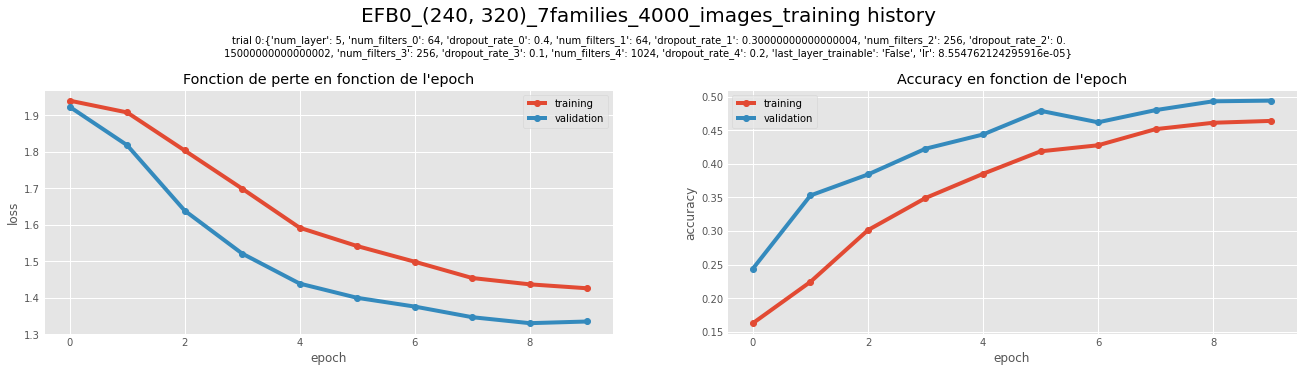

[I 2022-02-01 14:13:16,554] Trial 0 finished with value: 0.49395161867141724 and parameters: {'num_layer': 5, 'num_filters_0': 64, 'dropout_rate_0': 0.4, 'num_filters_1': 64, 'dropout_rate_1': 0.30000000000000004, 'num_filters_2': 256, 'dropout_rate_2': 0.15000000000000002, 'num_filters_3': 256, 'dropout_rate_3': 0.1, 'num_filters_4': 1024, 'dropout_rate_4': 0.2, 'last_layer_trainable': 'False', 'lr': 8.554762124295916e-05}. Best is trial 0 with value: 0.49395161867141724.


************************************************************************************************************************
trial 1:{'num_layer': 3, 'num_filters_0': 64, 'dropout_rate_0': 0.2, 'num_filters_1': 128, 'dropout_rate_1': 0.30000000000000004, 'num_filters_2': 32, 'dropout_rate_2': 0.45, 'last_layer_trainable': 'True', 'lr': 0.002720705036530616}
Epoch 1/10
125/125 [==============================] - 21s 126ms/step - loss: 1.8395 - accuracy: 0.2560 - val_loss: 1.5941 - val_accuracy: 0.3810 - lr: 0.0027
Epoch 2/10
125/125 [==============================] - 14s 116ms/step - loss: 1.6160 - accuracy: 0.3823 - val_loss: 1.4168 - val_accuracy: 0.5010 - lr: 0.0027
Epoch 3/10
125/125 [==============================] - 14s 115ms/step - loss: 1.5003 - accuracy: 0.4378 - val_loss: 1.3419 - val_accuracy: 0.5171 - lr: 0.0027
Epoch 4/10
125/125 [==============================] - 15s 116ms/step - loss: 1.4150 - accuracy: 0.4807 - val_loss: 1.3166 - val_accuracy: 0.5262 - lr: 0.0027
Epoch 5/10
1

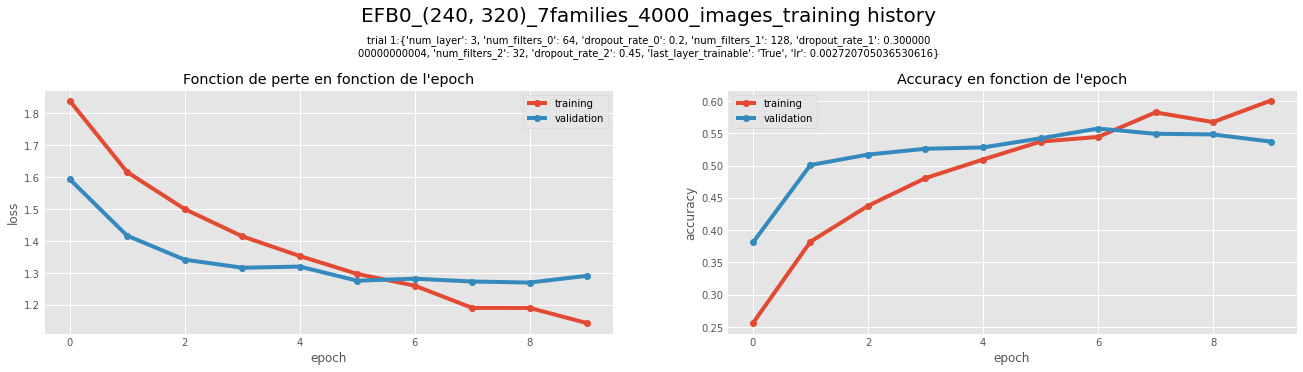

[I 2022-02-01 14:16:18,764] Trial 1 finished with value: 0.5372983813285828 and parameters: {'num_layer': 3, 'num_filters_0': 64, 'dropout_rate_0': 0.2, 'num_filters_1': 128, 'dropout_rate_1': 0.30000000000000004, 'num_filters_2': 32, 'dropout_rate_2': 0.45, 'last_layer_trainable': 'True', 'lr': 0.002720705036530616}. Best is trial 1 with value: 0.5372983813285828.


************************************************************************************************************************
trial 2:{'num_layer': 3, 'num_filters_0': 128, 'dropout_rate_0': 0.30000000000000004, 'num_filters_1': 512, 'dropout_rate_1': 0.05, 'num_filters_2': 512, 'dropout_rate_2': 0.35000000000000003, 'last_layer_trainable': 'False', 'lr': 0.006571971519344987}
Epoch 1/10
125/125 [==============================] - 21s 129ms/step - loss: 1.8365 - accuracy: 0.2695 - val_loss: 1.6077 - val_accuracy: 0.3942 - lr: 0.0066
Epoch 2/10
125/125 [==============================] - 15s 116ms/step - loss: 1.6338 - accuracy: 0.3848 - val_loss: 1.4497 - val_accuracy: 0.4526 - lr: 0.0066
Epoch 3/10
125/125 [==============================] - 14s 115ms/step - loss: 1.5769 - accuracy: 0.4083 - val_loss: 1.4487 - val_accuracy: 0.4778 - lr: 0.0066
Epoch 4/10
125/125 [==============================] - 15s 117ms/step - loss: 1.5242 - accuracy: 0.4408 - val_loss: 1.3830 - val_accuracy: 0.4919 - lr: 

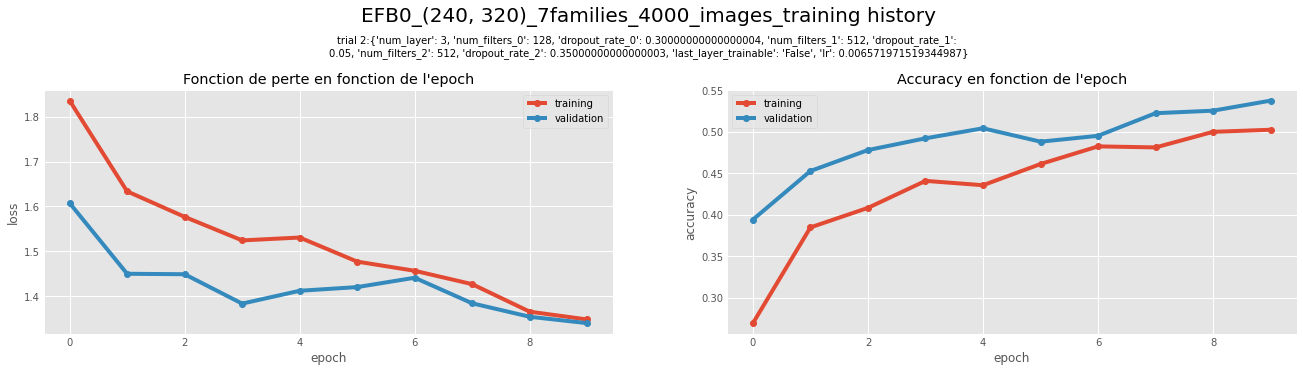

[I 2022-02-01 14:19:20,636] Trial 2 finished with value: 0.5372983813285828 and parameters: {'num_layer': 3, 'num_filters_0': 128, 'dropout_rate_0': 0.30000000000000004, 'num_filters_1': 512, 'dropout_rate_1': 0.05, 'num_filters_2': 512, 'dropout_rate_2': 0.35000000000000003, 'last_layer_trainable': 'False', 'lr': 0.006571971519344987}. Best is trial 1 with value: 0.5372983813285828.


************************************************************************************************************************
trial 3:{'num_layer': 3, 'num_filters_0': 128, 'dropout_rate_0': 0.1, 'num_filters_1': 2048, 'dropout_rate_1': 0.1, 'num_filters_2': 128, 'dropout_rate_2': 0.2, 'last_layer_trainable': 'True', 'lr': 0.0001071928979926242}
Epoch 1/10
125/125 [==============================] - 21s 127ms/step - loss: 1.8158 - accuracy: 0.3025 - val_loss: 1.5711 - val_accuracy: 0.4264 - lr: 1.0719e-04
Epoch 2/10
125/125 [==============================] - 15s 117ms/step - loss: 1.4703 - accuracy: 0.4560 - val_loss: 1.3523 - val_accuracy: 0.5010 - lr: 1.0719e-04
Epoch 3/10
125/125 [==============================] - 15s 116ms/step - loss: 1.3144 - accuracy: 0.5180 - val_loss: 1.2651 - val_accuracy: 0.5212 - lr: 1.0719e-04
Epoch 4/10
125/125 [==============================] - 14s 116ms/step - loss: 1.2300 - accuracy: 0.5445 - val_loss: 1.2275 - val_accuracy: 0.5353 - lr: 1.0719e-04
Epoch 5/1

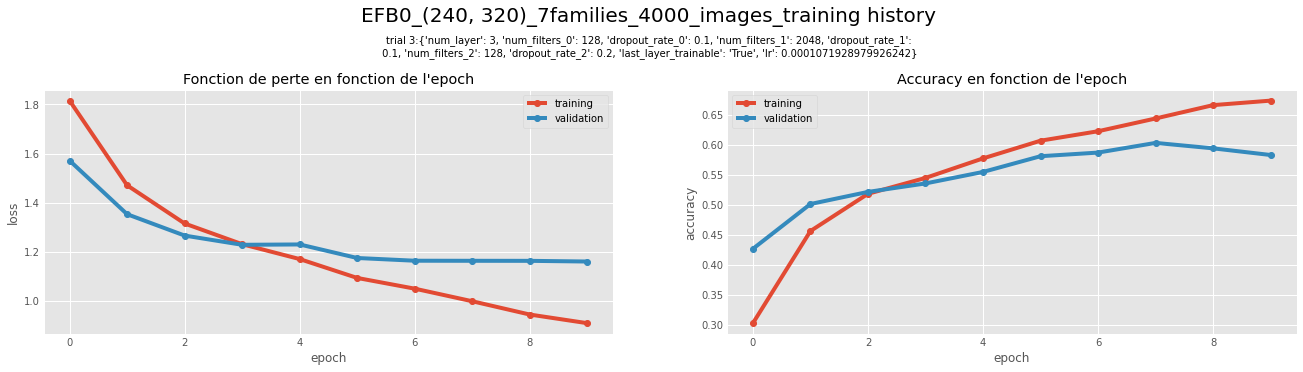

[I 2022-02-01 14:22:35,609] Trial 3 finished with value: 0.5826612710952759 and parameters: {'num_layer': 3, 'num_filters_0': 128, 'dropout_rate_0': 0.1, 'num_filters_1': 2048, 'dropout_rate_1': 0.1, 'num_filters_2': 128, 'dropout_rate_2': 0.2, 'last_layer_trainable': 'True', 'lr': 0.0001071928979926242}. Best is trial 3 with value: 0.5826612710952759.


************************************************************************************************************************
trial 4:{'num_layer': 4, 'num_filters_0': 256, 'dropout_rate_0': 0.35000000000000003, 'num_filters_1': 1024, 'dropout_rate_1': 0.1, 'num_filters_2': 64, 'dropout_rate_2': 0.25, 'num_filters_3': 128, 'dropout_rate_3': 0.45, 'last_layer_trainable': 'True', 'lr': 0.0008382968927127617}
Epoch 1/10
125/125 [==============================] - 21s 128ms/step - loss: 1.8140 - accuracy: 0.2705 - val_loss: 1.5155 - val_accuracy: 0.4264 - lr: 8.3830e-04
Epoch 2/10
125/125 [==============================] - ETA: 0s - loss: 1.5818 - accuracy: 0.3952

[I 2022-02-01 14:23:12,184] Trial 4 pruned. Trial was pruned at epoch 1.


************************************************************************************************************************
trial 5:{'num_layer': 3, 'num_filters_0': 512, 'dropout_rate_0': 0.2, 'num_filters_1': 64, 'dropout_rate_1': 0.05, 'num_filters_2': 64, 'dropout_rate_2': 0.1, 'last_layer_trainable': 'False', 'lr': 0.0002720821898147583}
Epoch 1/10
125/125 [==============================] - 21s 127ms/step - loss: 1.6812 - accuracy: 0.3593 - val_loss: 1.3618 - val_accuracy: 0.4970 - lr: 2.7208e-04
Epoch 2/10
125/125 [==============================] - 15s 117ms/step - loss: 1.3457 - accuracy: 0.5205 - val_loss: 1.2499 - val_accuracy: 0.5383 - lr: 2.7208e-04
Epoch 3/10
125/125 [==============================] - 15s 116ms/step - loss: 1.2157 - accuracy: 0.5625 - val_loss: 1.1969 - val_accuracy: 0.5625 - lr: 2.7208e-04
Epoch 4/10
125/125 [==============================] - 15s 117ms/step - loss: 1.1189 - accuracy: 0.5968 - val_loss: 1.1558 - val_accuracy: 0.5827 - lr: 2.7208e-04
Epoch 5/10

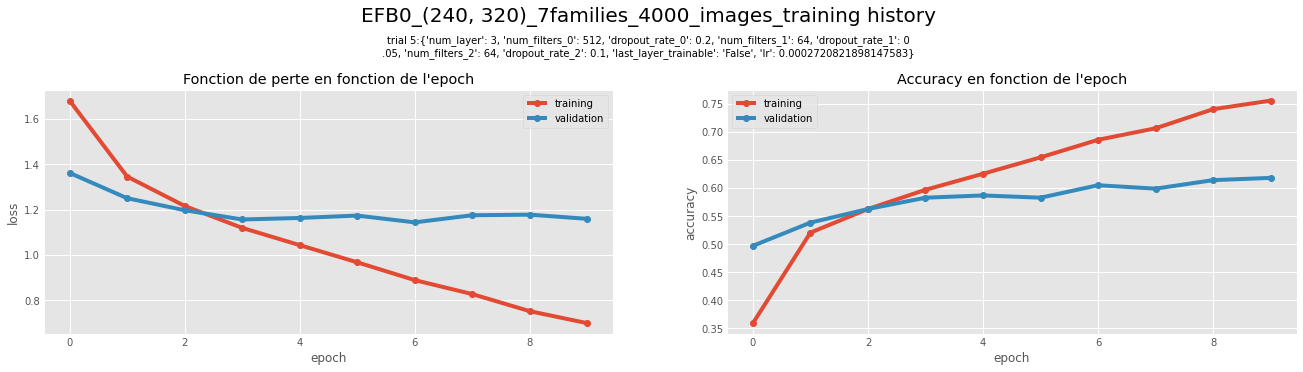

[I 2022-02-01 14:26:15,347] Trial 5 finished with value: 0.617943525314331 and parameters: {'num_layer': 3, 'num_filters_0': 512, 'dropout_rate_0': 0.2, 'num_filters_1': 64, 'dropout_rate_1': 0.05, 'num_filters_2': 64, 'dropout_rate_2': 0.1, 'last_layer_trainable': 'False', 'lr': 0.0002720821898147583}. Best is trial 5 with value: 0.617943525314331.


************************************************************************************************************************
trial 6:{'num_layer': 4, 'num_filters_0': 512, 'dropout_rate_0': 0.4, 'num_filters_1': 128, 'dropout_rate_1': 0.25, 'num_filters_2': 32, 'dropout_rate_2': 0.30000000000000004, 'num_filters_3': 64, 'dropout_rate_3': 0.0, 'last_layer_trainable': 'False', 'lr': 0.0014750410473777697}
Epoch 1/10
125/125 [==============================] - 21s 128ms/step - loss: 1.8148 - accuracy: 0.2630 - val_loss: 1.5233 - val_accuracy: 0.4083 - lr: 0.0015
Epoch 2/10
125/125 [==============================] - ETA: 0s - loss: 1.5944 - accuracy: 0.3830

[I 2022-02-01 14:26:51,780] Trial 6 pruned. Trial was pruned at epoch 1.


************************************************************************************************************************
trial 7:{'num_layer': 3, 'num_filters_0': 2048, 'dropout_rate_0': 0.1, 'num_filters_1': 32, 'dropout_rate_1': 0.15000000000000002, 'num_filters_2': 128, 'dropout_rate_2': 0.1, 'last_layer_trainable': 'True', 'lr': 0.0769574284925474}
Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 12.2181 - accuracy: 0.1425

[I 2022-02-01 14:27:19,643] Trial 7 pruned. Trial was pruned at epoch 0.


************************************************************************************************************************
trial 8:{'num_layer': 3, 'num_filters_0': 256, 'dropout_rate_0': 0.05, 'num_filters_1': 32, 'dropout_rate_1': 0.4, 'num_filters_2': 256, 'dropout_rate_2': 0.4, 'last_layer_trainable': 'True', 'lr': 4.353019637627309e-05}
Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 1.9492 - accuracy: 0.1605

[I 2022-02-01 14:27:43,776] Trial 8 pruned. Trial was pruned at epoch 0.


************************************************************************************************************************
trial 9:{'num_layer': 3, 'num_filters_0': 32, 'dropout_rate_0': 0.4, 'num_filters_1': 1024, 'dropout_rate_1': 0.15000000000000002, 'num_filters_2': 512, 'dropout_rate_2': 0.0, 'last_layer_trainable': 'False', 'lr': 0.00010727669368130632}
Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 1.9153 - accuracy: 0.2222

[I 2022-02-01 14:28:05,600] Trial 9 pruned. Trial was pruned at epoch 0.


************************************************************************************************************************
trial 10:{'num_layer': 2, 'num_filters_0': 512, 'dropout_rate_0': 0.5, 'num_filters_1': 64, 'dropout_rate_1': 0.0, 'last_layer_trainable': 'False', 'lr': 0.00039540138836643805}
Epoch 1/10
125/125 [==============================] - 21s 128ms/step - loss: 1.6495 - accuracy: 0.3663 - val_loss: 1.3337 - val_accuracy: 0.5212 - lr: 3.9540e-04
Epoch 2/10
125/125 [==============================] - 15s 116ms/step - loss: 1.3444 - accuracy: 0.5073 - val_loss: 1.2174 - val_accuracy: 0.5736 - lr: 3.9540e-04
Epoch 3/10
125/125 [==============================] - 15s 118ms/step - loss: 1.2033 - accuracy: 0.5590 - val_loss: 1.1853 - val_accuracy: 0.5736 - lr: 3.9540e-04
Epoch 4/10
125/125 [==============================] - 15s 117ms/step - loss: 1.1176 - accuracy: 0.5980 - val_loss: 1.1889 - val_accuracy: 0.5655 - lr: 3.9540e-04
Epoch 5/10
125/125 [==============================] -

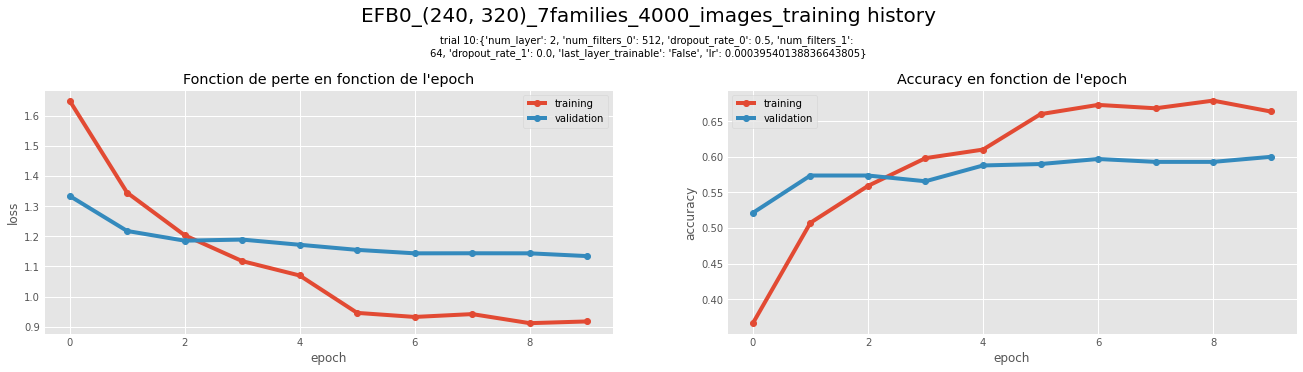

[I 2022-02-01 14:31:30,871] Trial 10 finished with value: 0.5997983813285828 and parameters: {'num_layer': 2, 'num_filters_0': 512, 'dropout_rate_0': 0.5, 'num_filters_1': 64, 'dropout_rate_1': 0.0, 'last_layer_trainable': 'False', 'lr': 0.00039540138836643805}. Best is trial 5 with value: 0.617943525314331.


************************************************************************************************************************
trial 11:{'num_layer': 2, 'num_filters_0': 512, 'dropout_rate_0': 0.5, 'num_filters_1': 64, 'dropout_rate_1': 0.0, 'last_layer_trainable': 'False', 'lr': 0.0005936386906260255}
Epoch 1/10
125/125 [==============================] - 21s 127ms/step - loss: 1.6169 - accuracy: 0.3742 - val_loss: 1.3620 - val_accuracy: 0.4808 - lr: 5.9364e-04
Epoch 2/10
125/125 [==============================] - 15s 116ms/step - loss: 1.3239 - accuracy: 0.5055 - val_loss: 1.2538 - val_accuracy: 0.5343 - lr: 5.9364e-04
Epoch 3/10
125/125 [==============================] - 15s 117ms/step - loss: 1.1876 - accuracy: 0.5665 - val_loss: 1.1841 - val_accuracy: 0.5726 - lr: 5.9364e-04
Epoch 4/10
125/125 [==============================] - 15s 117ms/step - loss: 1.1088 - accuracy: 0.5885 - val_loss: 1.2001 - val_accuracy: 0.5706 - lr: 5.9364e-04
Epoch 5/10
125/125 [==============================] - 

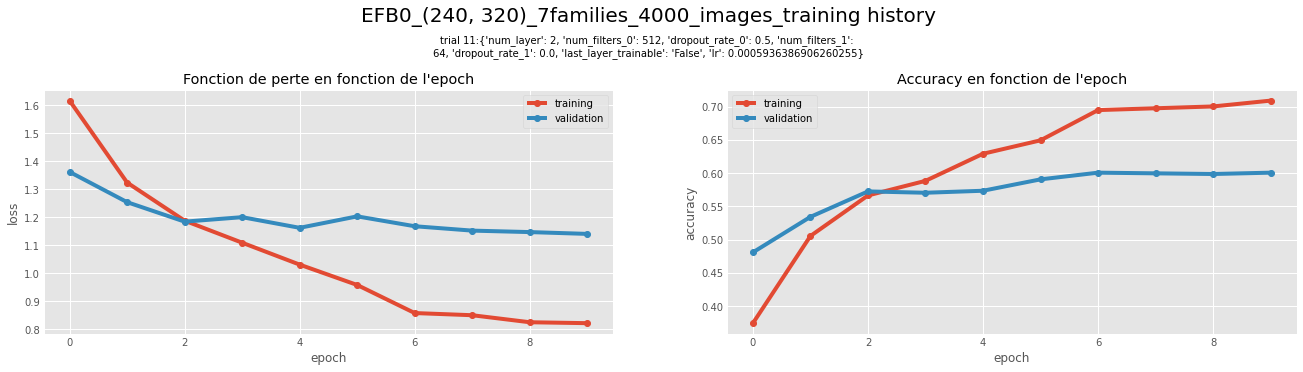

[I 2022-02-01 14:34:38,935] Trial 11 finished with value: 0.600806474685669 and parameters: {'num_layer': 2, 'num_filters_0': 512, 'dropout_rate_0': 0.5, 'num_filters_1': 64, 'dropout_rate_1': 0.0, 'last_layer_trainable': 'False', 'lr': 0.0005936386906260255}. Best is trial 5 with value: 0.617943525314331.


************************************************************************************************************************
trial 12:{'num_layer': 2, 'num_filters_0': 512, 'dropout_rate_0': 0.2, 'num_filters_1': 64, 'dropout_rate_1': 0.0, 'last_layer_trainable': 'False', 'lr': 1.334355895385519e-05}
Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 1.9593 - accuracy: 0.1848

[I 2022-02-01 14:35:00,951] Trial 12 pruned. Trial was pruned at epoch 0.


************************************************************************************************************************
trial 13:{'num_layer': 2, 'num_filters_0': 1024, 'dropout_rate_0': 0.25, 'num_filters_1': 256, 'dropout_rate_1': 0.5, 'last_layer_trainable': 'False', 'lr': 0.012110210512411745}
Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 1.9942 - accuracy: 0.3133

[I 2022-02-01 14:35:27,106] Trial 13 pruned. Trial was pruned at epoch 0.


************************************************************************************************************************
trial 14:{'num_layer': 2, 'num_filters_0': 512, 'dropout_rate_0': 0.5, 'num_filters_1': 64, 'dropout_rate_1': 0.2, 'last_layer_trainable': 'False', 'lr': 0.00039841429217466395}
Epoch 1/10
125/125 [==============================] - 21s 130ms/step - loss: 1.7388 - accuracy: 0.3352 - val_loss: 1.4175 - val_accuracy: 0.4798 - lr: 3.9841e-04
Epoch 2/10
125/125 [==============================] - 15s 118ms/step - loss: 1.4282 - accuracy: 0.4672 - val_loss: 1.2619 - val_accuracy: 0.5413 - lr: 3.9841e-04
Epoch 3/10
125/125 [==============================] - 15s 118ms/step - loss: 1.3172 - accuracy: 0.5163 - val_loss: 1.2252 - val_accuracy: 0.5595 - lr: 3.9841e-04
Epoch 4/10
125/125 [==============================] - 15s 118ms/step - loss: 1.2284 - accuracy: 0.5525 - val_loss: 1.1977 - val_accuracy: 0.5635 - lr: 3.9841e-04
Epoch 5/10
125/125 [==============================] -

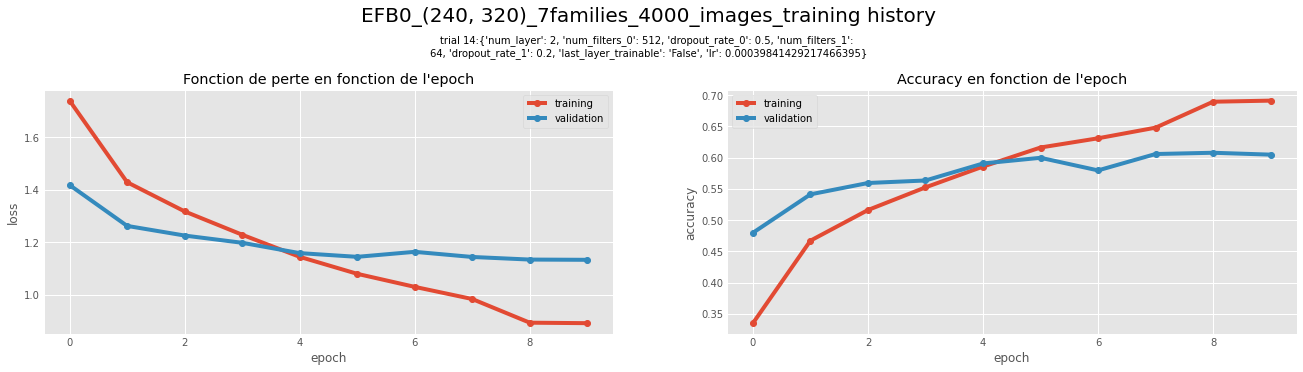

[I 2022-02-01 14:38:21,067] Trial 14 finished with value: 0.6048387289047241 and parameters: {'num_layer': 2, 'num_filters_0': 512, 'dropout_rate_0': 0.5, 'num_filters_1': 64, 'dropout_rate_1': 0.2, 'last_layer_trainable': 'False', 'lr': 0.00039841429217466395}. Best is trial 5 with value: 0.617943525314331.


************************************************************************************************************************
trial 15:{'num_layer': 4, 'num_filters_0': 512, 'dropout_rate_0': 0.15000000000000002, 'num_filters_1': 64, 'dropout_rate_1': 0.2, 'num_filters_2': 64, 'dropout_rate_2': 0.0, 'num_filters_3': 2048, 'dropout_rate_3': 0.45, 'last_layer_trainable': 'False', 'lr': 0.00031057905631518435}
Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 1.7038 - accuracy: 0.3435

[I 2022-02-01 14:38:43,387] Trial 15 pruned. Trial was pruned at epoch 0.


************************************************************************************************************************
trial 16:{'num_layer': 2, 'num_filters_0': 32, 'dropout_rate_0': 0.30000000000000004, 'num_filters_1': 256, 'dropout_rate_1': 0.35000000000000003, 'last_layer_trainable': 'False', 'lr': 1.088859089670835e-05}
Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 1.9611 - accuracy: 0.1410

[I 2022-02-01 14:39:09,638] Trial 16 pruned. Trial was pruned at epoch 0.


************************************************************************************************************************
trial 17:{'num_layer': 5, 'num_filters_0': 2048, 'dropout_rate_0': 0.0, 'num_filters_1': 2048, 'dropout_rate_1': 0.2, 'num_filters_2': 1024, 'dropout_rate_2': 0.1, 'num_filters_3': 512, 'dropout_rate_3': 0.25, 'num_filters_4': 2048, 'dropout_rate_4': 0.5, 'last_layer_trainable': 'False', 'lr': 0.00023451476046110008}
Epoch 1/10
125/125 [==============================] - 22s 131ms/step - loss: 1.6668 - accuracy: 0.3425 - val_loss: 1.3529 - val_accuracy: 0.4889 - lr: 2.3451e-04
Epoch 2/10
125/125 [==============================] - ETA: 0s - loss: 1.2980 - accuracy: 0.5253

[I 2022-02-01 14:39:55,356] Trial 17 pruned. Trial was pruned at epoch 1.


************************************************************************************************************************
trial 18:{'num_layer': 2, 'num_filters_0': 1024, 'dropout_rate_0': 0.25, 'num_filters_1': 64, 'dropout_rate_1': 0.1, 'last_layer_trainable': 'False', 'lr': 0.0028394255755746145}
Epoch 1/10
125/125 [==============================] - 21s 129ms/step - loss: 1.6283 - accuracy: 0.3965 - val_loss: 1.3344 - val_accuracy: 0.5040 - lr: 0.0028
Epoch 2/10
125/125 [==============================] - 15s 118ms/step - loss: 1.3362 - accuracy: 0.5140 - val_loss: 1.2381 - val_accuracy: 0.5464 - lr: 0.0028
Epoch 3/10
125/125 [==============================] - 15s 118ms/step - loss: 1.2132 - accuracy: 0.5533 - val_loss: 1.2176 - val_accuracy: 0.5615 - lr: 0.0028
Epoch 4/10
125/125 [==============================] - 15s 118ms/step - loss: 1.1100 - accuracy: 0.5962 - val_loss: 1.2421 - val_accuracy: 0.5806 - lr: 0.0028
Epoch 5/10
125/125 [==============================] - 15s 118ms/step

[I 2022-02-01 14:41:52,759] Trial 18 pruned. Trial was pruned at epoch 5.


************************************************************************************************************************
trial 19:{'num_layer': 4, 'num_filters_0': 512, 'dropout_rate_0': 0.45, 'num_filters_1': 512, 'dropout_rate_1': 0.2, 'num_filters_2': 2048, 'dropout_rate_2': 0.5, 'num_filters_3': 1024, 'dropout_rate_3': 0.25, 'last_layer_trainable': 'False', 'lr': 0.018578242398773197}
Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 5.4874 - accuracy: 0.1370

[I 2022-02-01 14:42:20,971] Trial 19 pruned. Trial was pruned at epoch 0.


************************************************************************************************************************
trial 20:{'num_layer': 2, 'num_filters_0': 512, 'dropout_rate_0': 0.30000000000000004, 'num_filters_1': 64, 'dropout_rate_1': 0.45, 'last_layer_trainable': 'False', 'lr': 2.7451490699146753e-05}
Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 1.9649 - accuracy: 0.1723

[I 2022-02-01 14:42:49,613] Trial 20 pruned. Trial was pruned at epoch 0.


************************************************************************************************************************
trial 21:{'num_layer': 2, 'num_filters_0': 512, 'dropout_rate_0': 0.5, 'num_filters_1': 64, 'dropout_rate_1': 0.0, 'last_layer_trainable': 'False', 'lr': 0.0006328119163222342}
Epoch 1/10
125/125 [==============================] - 22s 132ms/step - loss: 1.5994 - accuracy: 0.3783 - val_loss: 1.2675 - val_accuracy: 0.5444 - lr: 6.3281e-04
Epoch 2/10
125/125 [==============================] - 15s 121ms/step - loss: 1.3196 - accuracy: 0.5117 - val_loss: 1.2214 - val_accuracy: 0.5403 - lr: 6.3281e-04
Epoch 3/10
125/125 [==============================] - 15s 121ms/step - loss: 1.1957 - accuracy: 0.5692 - val_loss: 1.1715 - val_accuracy: 0.5685 - lr: 6.3281e-04
Epoch 4/10
125/125 [==============================] - 15s 122ms/step - loss: 1.1059 - accuracy: 0.6035 - val_loss: 1.1529 - val_accuracy: 0.5806 - lr: 6.3281e-04
Epoch 5/10
125/125 [==============================] - 

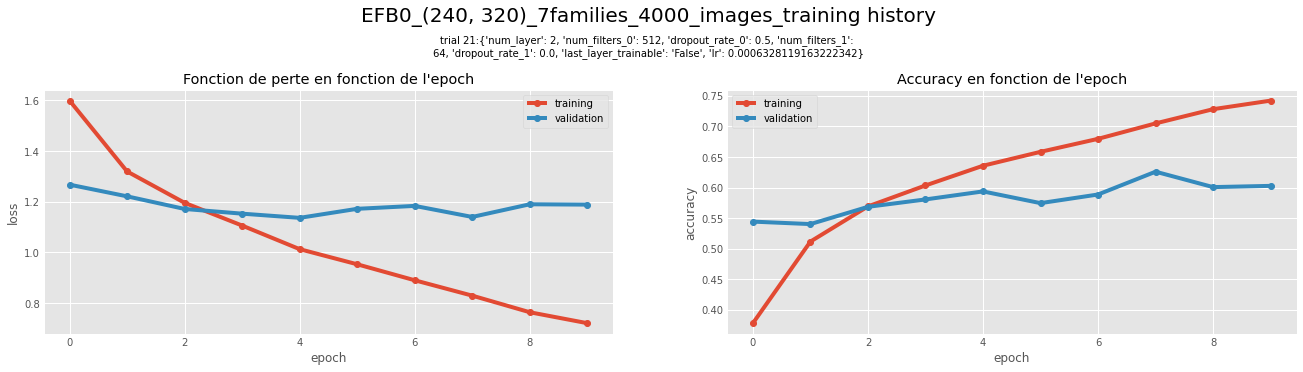

[I 2022-02-01 14:45:45,037] Trial 21 finished with value: 0.6028226017951965 and parameters: {'num_layer': 2, 'num_filters_0': 512, 'dropout_rate_0': 0.5, 'num_filters_1': 64, 'dropout_rate_1': 0.0, 'last_layer_trainable': 'False', 'lr': 0.0006328119163222342}. Best is trial 5 with value: 0.617943525314331.


************************************************************************************************************************
trial 22:{'num_layer': 2, 'num_filters_0': 512, 'dropout_rate_0': 0.5, 'num_filters_1': 64, 'dropout_rate_1': 0.05, 'last_layer_trainable': 'False', 'lr': 0.0001883220980478359}
Epoch 1/10
125/125 [==============================] - 22s 132ms/step - loss: 1.7444 - accuracy: 0.3315 - val_loss: 1.4350 - val_accuracy: 0.4859 - lr: 1.8832e-04
Epoch 2/10
125/125 [==============================] - ETA: 0s - loss: 1.4483 - accuracy: 0.4735

[I 2022-02-01 14:46:22,680] Trial 22 pruned. Trial was pruned at epoch 1.


************************************************************************************************************************
trial 23:{'num_layer': 3, 'num_filters_0': 512, 'dropout_rate_0': 0.45, 'num_filters_1': 64, 'dropout_rate_1': 0.05, 'num_filters_2': 64, 'dropout_rate_2': 0.05, 'last_layer_trainable': 'False', 'lr': 0.0018974574270828163}
Epoch 1/10
125/125 [==============================] - 22s 132ms/step - loss: 1.6602 - accuracy: 0.3710 - val_loss: 1.3593 - val_accuracy: 0.5151 - lr: 0.0019
Epoch 2/10
125/125 [==============================] - ETA: 0s - loss: 1.3898 - accuracy: 0.4865

[I 2022-02-01 14:47:04,197] Trial 23 pruned. Trial was pruned at epoch 1.


************************************************************************************************************************
trial 24:{'num_layer': 2, 'num_filters_0': 512, 'dropout_rate_0': 0.45, 'num_filters_1': 64, 'dropout_rate_1': 0.15000000000000002, 'last_layer_trainable': 'False', 'lr': 0.0006743095664386257}
Epoch 1/10
125/125 [==============================] - 21s 131ms/step - loss: 1.6445 - accuracy: 0.3790 - val_loss: 1.3267 - val_accuracy: 0.5030 - lr: 6.7431e-04
Epoch 2/10
125/125 [==============================] - 16s 125ms/step - loss: 1.3474 - accuracy: 0.5025 - val_loss: 1.2710 - val_accuracy: 0.5393 - lr: 6.7431e-04
Epoch 3/10
125/125 [==============================] - ETA: 0s - loss: 1.2340 - accuracy: 0.5440

[I 2022-02-01 14:48:02,523] Trial 24 pruned. Trial was pruned at epoch 2.


time: 37min 59s (started: 2022-02-01 14:10:02 +00:00)


In [124]:
def objective2(trial):
  print('*'*120)
   # base model layers 
  # base_model =base_model 
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D() 
  layers = [ base_model,  global_average_layer ]
  # define a number of classifier layers 
  num_layer = trial.suggest_int("num_layer", 2, 5) #number of the convolution + drop out layers
  # create dict of layers with variouus unit numer & dropout  
  layer_properties = {}
  for i in range(num_layer):  
    units = trial.suggest_categorical("num_filters_" + str(i), [32, 64, 128, 256, 512,1024,2048])
    dropout = trial.suggest_discrete_uniform('dropout_rate_'+ str(i), 0.0, 0.5,0.05)
    layer_properties[i] = [units,dropout]
  # add classifiers layers (succession de Dense + dropout ) 
  for k,v in layer_properties.items():
    units,dropout = v
    layers.append(tf.keras.layers.Dense(units = units, activation = 'relu'))
    layers.append(tf.keras.layers.Dropout(dropout))
  # add predICTION layers 
  layers.append(Dense(units = classes_count, activation = 'softmax'))
  #freeze/unfreeze all layers 
  for layer in base_model.layers:
      layer.trainable = base_model_trainable
  # freeze/unfreeze just the last layer
  last_layer_trainable = trial.suggest_categorical("last_layer_trainable", ["True", "False"])
  base_model.layers[-1:][0].trainable = True if last_layer_trainable == 'True' else False
  # build model 
  model = tf.keras.Sequential(layers,name = model_name)
  # optimizer 
  optimizer = "adam" #  trial.suggest_categorical("optimizer", ["sgd", "adam"]) 
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
  # compilation 
  model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
  K.set_value(model.optimizer.learning_rate, lr) #set learning rate 
  # Add a callback for pruning cf optuna 
  pruning_callback = optuna.integration.TFKerasPruningCallback(trial, "val_accuracy") # pruning sur le set d'evaluation 
  # csv start path infos 
  pathinfos = str(model.name) + '_' + str(resol) + '_' + str(family_number) + 'families_' + str(len(df_train)) + '_images'
  ## Entraînement
  text = 'trial ' + str(trial.number) + ':' + str(trial.params)
  print(text)
  training_history_model = model.fit(train_generator,
                                   epochs=epochs,
                                   steps_per_epoch = len(df_train)//batch_size,
                                  validation_data = test_generator,
                                  validation_steps = len(df_test)//batch_size,
                                   class_weight=class_weights,
                                  callbacks=[
                                             early_stopping,reduce_learning_rate, #KERAS
                                             pruning_callback # optuna 
                                             ])
  
  # Plot hIStory 
  training_history_fig = plot_history(training_history_model,pathinfos)
  # add trial infos
  t1, t2 = text[:len(text)//2],text[len(text)//2:]
  training_history_fig.text(0.5,0.85,t1 + '\n' + t2 ,ha= 'center',fontsize=10,wrap=True)
  display(training_history_fig)
  # save fig + model summary
  trial_infos =  '_trial' + str(trial.number)
  training_history_fig.savefig(export_dir + pathinfos +  trial_infos  +  '_training_history.jpeg' )
  with open(export_dir + pathinfos +  trial_infos  +  '_modelsummary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

  return training_history_model.history['val_accuracy'][-1]

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize',pruner=optuna.pruners.MedianPruner( n_startup_trials=3 ))
study.optimize(objective2, n_trials=n_trials,)

In [125]:
trial_df = study.trials_dataframe()
display(trial_df)
trial_df.to_csv(export_dir + 'optuna_trials.csv')

,number,value,datetime_start,datetime_complete,duration,params_dropout_rate_0,params_dropout_rate_1,params_dropout_rate_2,params_dropout_rate_3,params_dropout_rate_4,params_last_layer_trainable,params_lr,params_num_filters_0,params_num_filters_1,params_num_filters_2,params_num_filters_3,params_num_filters_4,params_num_layer,state
0,0,0.493952,2022-02-01 14:10:03.040562,2022-02-01 14:13:16.553928,0 days 00:03:13.513366,0.40,0.30,0.15,0.10,0.2,False,0.000086,64,64,256.0,256.0,1024.0,5,COMPLETE
1,1,0.537298,2022-02-01 14:13:16.555924,2022-02-01 14:16:18.763486,0 days 00:03:02.207562,0.20,0.30,0.45,NaN,NaN,True,0.002721,64,128,32.0,NaN,NaN,3,COMPLETE
2,2,0.537298,2022-02-01 14:16:18.765400,2022-02-01 14:19:20.635322,0 days 00:03:01.869922,0.30,0.05,0.35,NaN,NaN,False,0.006572,128,512,512.0,NaN,NaN,3,COMPLETE
3,3,0.582661,2022-02-01 14:19:20.637844,2022-02-01 14:22:35.609362,0 days 00:03:14.971518,0.10,0.10,0.20,NaN,NaN,True,0.000107,128,2048,128.0,NaN,NaN,3,COMPLETE
4,4,0.452621,2022-02-01 14:22:35.611128,2022-02-01 14:23:12.184426,0 days 00:00:36.573298,0.35,0.10,0.25,0.45,NaN,True,0.000838,256,1024,64.0,128.0,NaN,4,PRUNED
5,5,0.617944,2022-02-01 14:23:12.186154,2022-02-01 14:26:15.347008,0 days 00:03:03.160854,0.20,0.05,0.10,NaN,NaN,False,0.000272,512,64,64.0,NaN,NaN,3,COMPLETE
6,6,0.450605,2022-02-01 14:26:15.348756,2022-02-01 14:26:51.780834,0 days 00:00:36.432078,0.40,0.25,0.30,0.00,NaN,False,0.001475,512,128,32.0,64.0,NaN,4,PRUNED
7,7,0.170363,2022-02-01 14:26:51.782312,2022-02-01 14:27:19.643888,0 days 00:00:27.861576,0.10,0.15,0.10,NaN,NaN,True,0.076957,2048,32,128.0,NaN,NaN,3,PRUNED
8,8,0.240927,2022-02-01 14:27:19.645596,2022-02-01 14:27:43.776606,0 days 00:00:24.131010,0.05,0.40,0.40,NaN,NaN,True,0.000044,256,32,256.0,NaN,NaN,3,PRUNED
9,9,0.344758,2022-02-01 14:27:43.778254,2022-02-01 14:28:05.600750,0 days 00:00:21.822496,0.40,0.15,0.00,NaN,NaN,False,0.000107,32,1024,512.0,NaN,NaN,3,PRUNED


time: 5 s (started: 2022-02-01 14:48:02 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



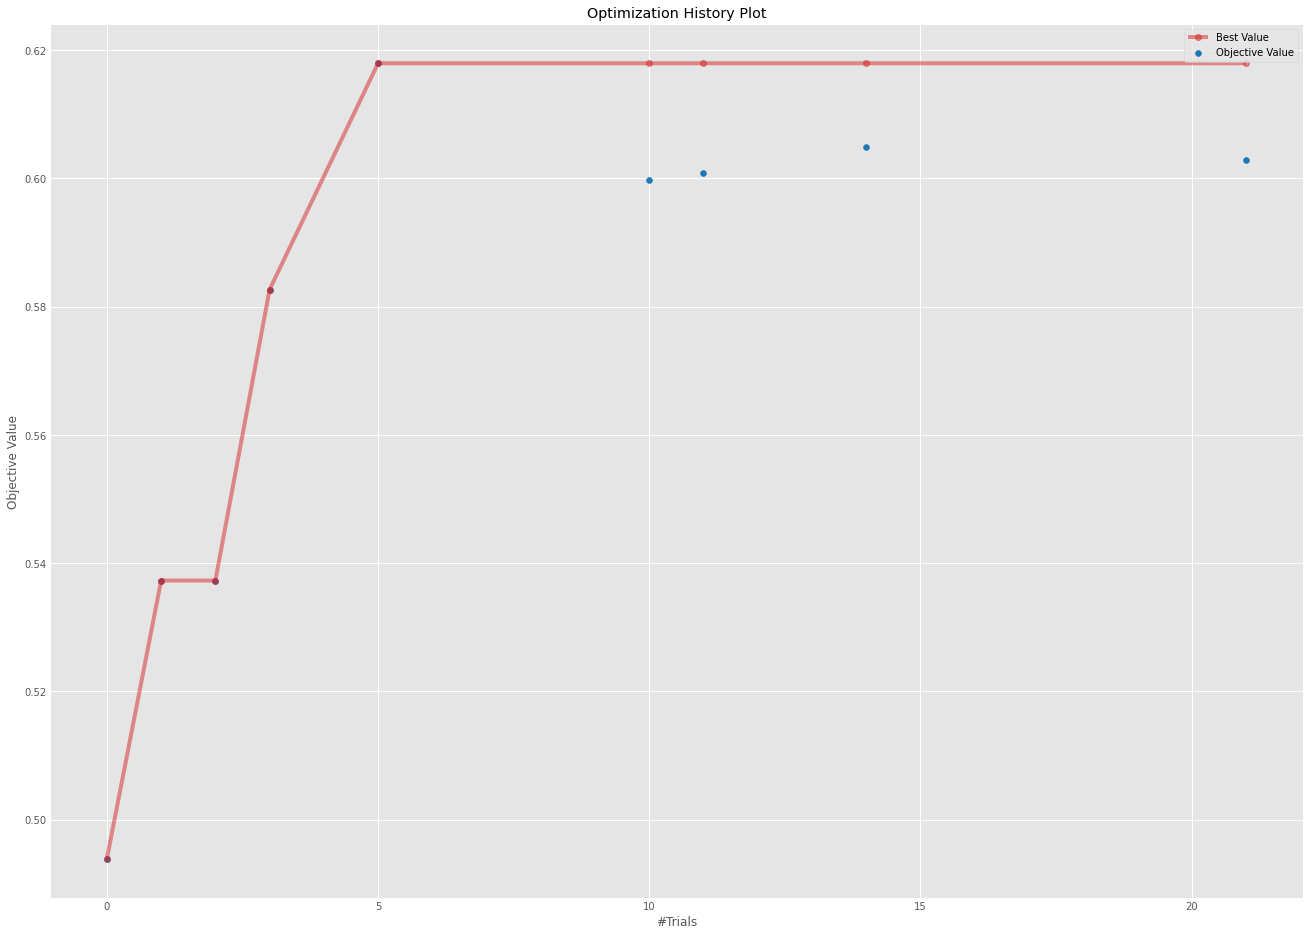

time: 454 ms (started: 2022-02-01 14:48:07 +00:00)


In [126]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)
plt.savefig(export_dir + pathinfos +  '_plot_optimization_history.jpeg',bbox_inches='tight'  )

In [127]:
fig = optuna.visualization.plot_intermediate_values(study)
plt.savefig(export_dir + pathinfos +  '_plot_intermediate_values.jpeg' )

<Figure size 1440x1080 with 0 Axes>

time: 78.1 ms (started: 2022-02-01 14:48:08 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ExperimentalWarning:

plot_slice is experimental (supported from v2.2.0). The interface can change in the future.

/usr/local/lib/python3.7/dist-packages/optuna/visualization/matplotlib/_slice.py:188: UserWarning:

Attempting to set identical left == right == 0.1 results in singular transformations; automatically expanding.

/usr/local/lib/python3.7/dist-packages/optuna/visualization/matplotlib/_slice.py:188: UserWarning:

Attempting to set identical left == right == 0.2 results in singular transformations; automatically expanding.

/usr/local/lib/python3.7/dist-packages/optuna/visualization/matplotlib/_slice.py:188: UserWarning:

Attempting to set identical left == right == 256.0 results in singular transformations; automatically expanding.

/usr/local/lib/python3.7/dist-packages/optuna/visualization/matplotlib/_slice.py:188: UserWarning:

Attempting to set identical left == right == 1024.0 results in singular transformat

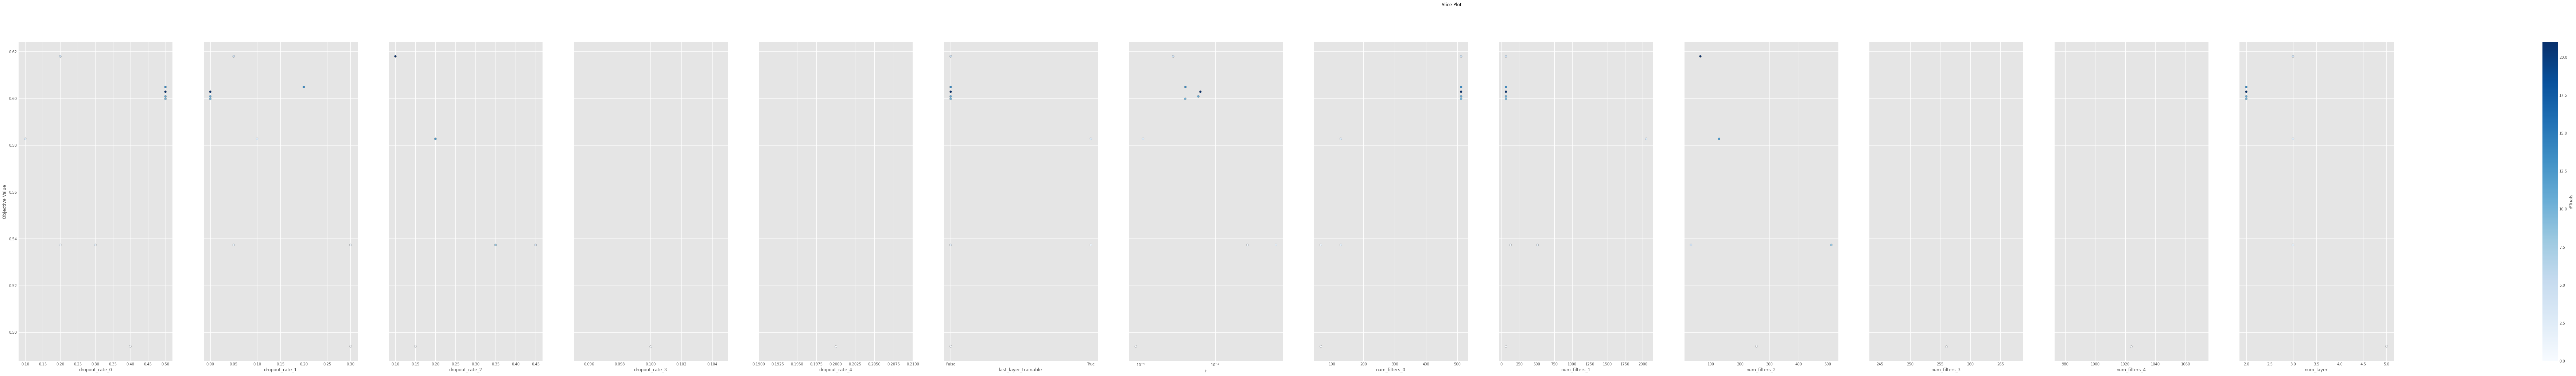

time: 4.15 s (started: 2022-02-01 14:48:08 +00:00)


In [128]:
fig = optuna.visualization.matplotlib.plot_slice(study)
plt.savefig(export_dir + pathinfos +  '_plot_slice.jpeg',bbox_inches='tight' )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ExperimentalWarning:

plot_contour is experimental (supported from v2.2.0). The interface can change in the future.

[W 2022-02-01 14:48:12,260] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
[W 2022-02-01 14:48:23,117] Param dropout_rate_3 unique value length is less than 2.
[W 2022-02-01 14:48:23,118] Param dropout_rate_4 unique value length is less than 2.
[W 2022-02-01 14:48:41,601] Param num_filters_3 unique value length is less than 2.
[W 2022-02-01 14:48:41,603] Param num_filters_4 unique value length is less than 2.
[W 2022-02-01 14:48:52,305] Param dropout_rate_3 unique value length is less than 2.
[W 2022-02-01 14:48:52,306] Param dropout_rate_4 unique value length is less than 2.
[W 2022-02-01 14:49:10,195] Param num_filters_3 unique value length is less than 2.
[W 2022-02-01 14:49:10,196] Param num_filters_4 unique value length i

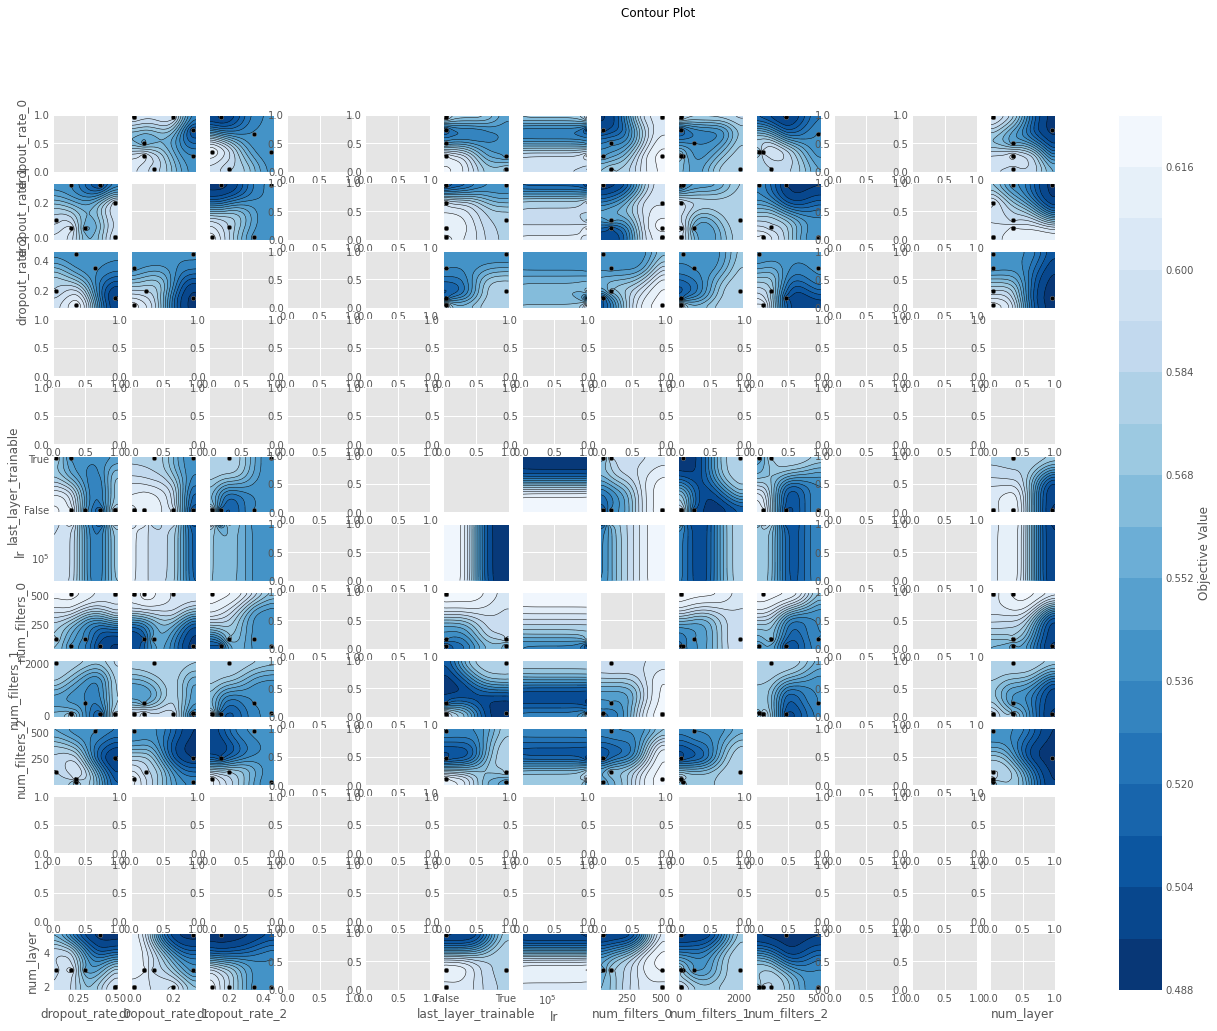

time: 5min 5s (started: 2022-02-01 14:48:12 +00:00)


In [129]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 25,15
optuna.visualization.matplotlib.plot_contour(study) #DEBUG,['num_filters_0','lr']
plt.savefig(export_dir + pathinfos +  '_plot_contour.jpeg' ,bbox_inches='tight' )
rcParams['figure.figsize'] = 6.4, 4.8 #reset to default 

In [130]:
# optuna.visualization.plot_parallel_coordinate(study)

time: 1.02 ms (started: 2022-02-01 14:53:17 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



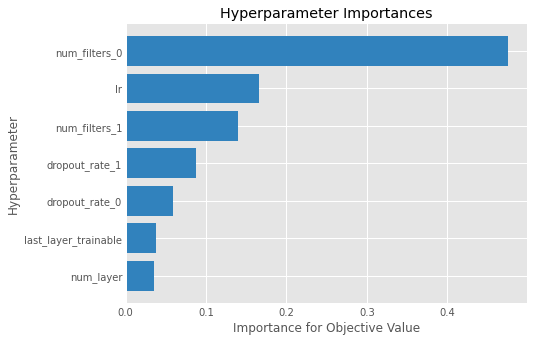

time: 634 ms (started: 2022-02-01 14:53:17 +00:00)


In [131]:
#Visualize parameter importances.
fig = optuna.visualization.matplotlib.plot_param_importances(study)
plt.savefig(export_dir + pathinfos +  '_plot_param_importances.jpeg' ,bbox_inches='tight' )

In [132]:
print('Best trial is number {}: score {},\nparams {}'.format(study.best_trial.number,study.best_trial.value,study.best_trial.params))

Best trial is number 5: score 0.617943525314331,
params {'num_layer': 3, 'num_filters_0': 512, 'dropout_rate_0': 0.2, 'num_filters_1': 64, 'dropout_rate_1': 0.05, 'num_filters_2': 64, 'dropout_rate_2': 0.1, 'last_layer_trainable': 'False', 'lr': 0.0002720821898147583}
time: 4.57 ms (started: 2022-02-01 14:53:18 +00:00)


# Best model fit

In [133]:
study.best_trial.params

{'dropout_rate_0': 0.2,
 'dropout_rate_1': 0.05,
 'dropout_rate_2': 0.1,
 'last_layer_trainable': 'False',
 'lr': 0.0002720821898147583,
 'num_filters_0': 512,
 'num_filters_1': 64,
 'num_filters_2': 64,
 'num_layer': 3}

time: 4.83 ms (started: 2022-02-01 14:53:18 +00:00)


In [134]:
# DEFINE BEST MODEL Param
num_layer = study.best_trial.params['num_layer']
lr = study.best_trial.params['lr']
last_layer_trainable= study.best_trial.params['last_layer_trainable']
layer_units, layer_dropouts = {}, {}
for k,v in study.best_trial.params.items():
  if 'num_filters' in k:
    layer_units[int(k[-1:])] = v
  if 'dropout_rate' in k:
    layer_dropouts[int(k[-1:])] = v


time: 7.77 ms (started: 2022-02-01 14:53:18 +00:00)


In [135]:
# construct model 
# base + average 
layers = [base_model,tf.keras.layers.GlobalAveragePooling2D()] 
# dense + dropout 
for i in range(num_layer):
      layers.append(tf.keras.layers.Dense(units =layer_units[i], activation = 'relu'))
      layers.append(tf.keras.layers.Dropout(layer_dropouts[i]))
# prediction 
layers.append(Dense(units = classes_count, activation = 'softmax'))
#freeze/unfreeze all layers 
for layer in base_model.layers:
    layer.trainable = base_model_trainable
# just the last layer
base_model.layers[-1:][0].trainable = True if last_layer_trainable == 'True' else False
#create model 
model = tf.keras.Sequential(layers,name = model_name)
model.summary()

Model: "EFB0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 8, 10, 1280)      4049571   
                                                                 
 global_average_pooling2d_68  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_290 (Dense)           (None, 512)               655872    
                                                                 
 dropout_225 (Dropout)       (None, 512)               0         
                                                                 
 dense_291 (Dense)           (None, 64)                32832     
                                                                 
 dropout_226 (Dropout)       (None, 64)                0         
                                                              

In [136]:
# compilation 
optimizer =  'Adam'
model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
K.set_value(model.optimizer.learning_rate, lr) #set learning rate 
# Entraînement
tic = time.time() # timer start
training_history_model = model.fit(train_generator,
                                   epochs=epochs,
                                   steps_per_epoch = len(df_train)//batch_size,
                                  validation_data = test_generator,
                                  validation_steps = len(df_test)//batch_size,
                                   class_weight=class_weights,
                                  callbacks=[
                                             early_stopping,reduce_learning_rate
                                             ])
# timer end 
tac = time.time()
time_to_fit = tic - tac

Epoch 1/10
125/125 [==============================] - 21s 129ms/step - loss: 1.6959 - accuracy: 0.3610 - val_loss: 1.3887 - val_accuracy: 0.5010 - lr: 2.7208e-04
Epoch 2/10
125/125 [==============================] - 15s 119ms/step - loss: 1.3718 - accuracy: 0.4988 - val_loss: 1.2760 - val_accuracy: 0.5484 - lr: 2.7208e-04
Epoch 3/10
125/125 [==============================] - 16s 127ms/step - loss: 1.2364 - accuracy: 0.5483 - val_loss: 1.1933 - val_accuracy: 0.5696 - lr: 2.7208e-04
Epoch 4/10
125/125 [==============================] - 15s 119ms/step - loss: 1.1500 - accuracy: 0.5985 - val_loss: 1.1600 - val_accuracy: 0.5837 - lr: 2.7208e-04
Epoch 5/10
125/125 [==============================] - 15s 117ms/step - loss: 1.0540 - accuracy: 0.6280 - val_loss: 1.1434 - val_accuracy: 0.5827 - lr: 2.7208e-04
Epoch 6/10
125/125 [==============================] - ETA: 0s - loss: 0.9779 - accuracy: 0.6543
Epoch 00006: ReduceLROnPlateau reducing learning rate to 2.7208219398744403e-06.
125/125 [====

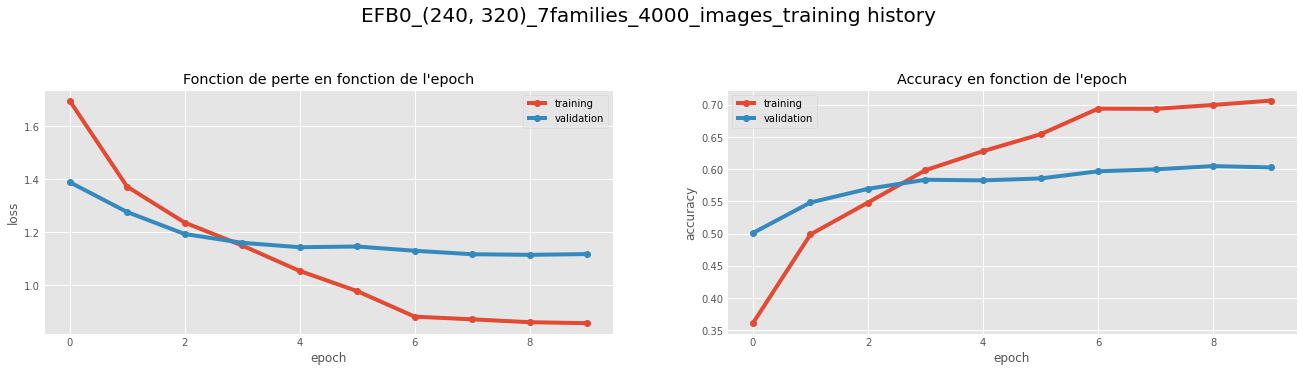

time: 331 ms (started: 2022-02-01 14:56:27 +00:00)


In [137]:
# save  & export history 
hist_df = pd.DataFrame(training_history_model.history)
hist_df.to_csv(export_dir + pathinfos + '_best_model_history.csv')
training_history_fig = plot_history(training_history_model,pathinfos)
display(training_history_fig)
training_history_fig.savefig(export_dir + pathinfos +  '_BEST model training_history.jpeg' )

# Assess

## Fonctions

In [138]:
def conf_matrix(y_test_class , test_pred_class,classes,df_label):
  ## Première étape, la matrice de confusion
  cnf_matrix = np.around(confusion_matrix(y_test_class , test_pred_class,normalize='pred'),2)*100

  ### Display a nice confusion matrix
  classes = range(0,(classes))
  fig = plt.figure(figsize=(15,5))

  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')

  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.grid(False)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, format(cnf_matrix[i, j],'.1f'),
              horizontalalignment = "center",
              color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels (%)')
  plt.xlabel('Labels prédits (%)')

  #add label dict 
  lab_dict = 'label, family, count  \n\n '
  lab_dict = lab_dict + str(df_label.values).replace("[","").replace("]","")
  lab_dict = re.sub(r'([0-9]+) ', r'\1, ', lab_dict)
  lab_dict = re.sub(r'([A-Za-z0-9]+\')', r'\1,', lab_dict)
  plt.text(len(classes)+2, (len(classes)+2)/2, lab_dict)
  #TILTLE 
  title =  pathinfos + '\n Test=' + str(len(y_test_class)) + ' images'
  plt.title(title, size=18,y=1.12,x=1)


  # plt.show()
  plt.close()
  return fig

time: 28.7 ms (started: 2022-02-01 14:56:28 +00:00)


##  Plots

In [139]:
# define X test 
X_test_path = df_test['drive_file_path']
X_test = []
for filepath in tqdm(X_test_path):
    # Lecture du fichier
    im = tf.io.read_file(filepath)
    # On décode le fichier
    im = tf.image.decode_jpeg(im, channels=3)
    # Redimensionnement
    im = tf.image.resize(im, size=resol)
    X_test.append([im])
    
X_test = tf.concat(X_test, axis=0)
# predict y_test
y_prob = model.predict(X_test, batch_size=16)
test_pred_class = tf.argmax(y_prob, axis = 1).numpy()
y_test_class= df_test['label'].astype(int) 
# report 
print(metrics.classification_report(y_test_class, test_pred_class))
# save report
report = metrics.classification_report(y_test_class, test_pred_class, output_dict=True)
report = pd.DataFrame(report).transpose()
report_path = export_dir + pathinfos + '_classification report.csv'
report.to_csv(report_path)

100%|██████████| 1000/1000 [00:02<00:00, 360.77it/s]


              precision    recall  f1-score   support

           0       0.61      0.57      0.59       171
           1       0.73      0.82      0.77       169
           2       0.62      0.67      0.64       126
           3       0.52      0.55      0.53       139
           4       0.65      0.68      0.67       133
           5       0.56      0.48      0.51       147
           6       0.47      0.42      0.44       115

    accuracy                           0.60      1000
   macro avg       0.59      0.60      0.59      1000
weighted avg       0.60      0.60      0.60      1000

time: 6.67 s (started: 2022-02-01 14:56:28 +00:00)


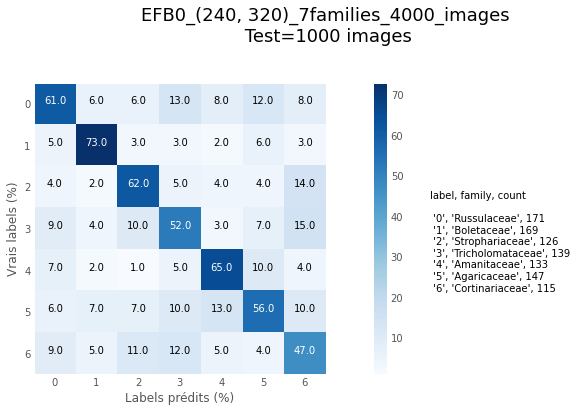

time: 624 ms (started: 2022-02-01 14:56:35 +00:00)


In [140]:
# conf matrix  
classes = df['gbif_info.family'].nunique()  # classes
# label and count for legend 
unique, counts = np.unique(y_test_class, return_counts=True)
test_dict_label = pd.DataFrame(zip(unique.astype(str), counts), columns=['label','y_test_count'])
test_dict_label = dict_label_df.merge(test_dict_label,on='label')
test_dict_label = test_dict_label.drop(['size'], axis=1)
# plot 
conf_matrix_fig = conf_matrix(y_test_class , test_pred_class,classes,test_dict_label)
display(conf_matrix_fig)
# save fig 
conf_matrix_fig.savefig(export_dir + pathinfos +  '_conf_matrix.jpeg' ,bbox_inches = 'tight')

In [141]:
training_epochs = len(training_history_model.history['loss'])
maxacc = round(max(training_history_model.history['accuracy']),2)
maxvalacc = round(max(training_history_model.history['val_accuracy']),2)
fit_time = -round(time_to_fit/60,1)
results_folder = os.path.basename(os.path.dirname(export_dir))
print('train/val acc={}/{} in {} epochs in {} minutes with model {} in folder {}'.format(maxacc,maxvalacc,training_epochs,fit_time,model.name,results_folder))

train/val acc=0.71/0.6 in 10 epochs in 3.1 minutes with model EFB0 in folder 220201_11H44
time: 4.02 ms (started: 2022-02-01 14:56:35 +00:00)


# Experiments (with 5000 images)
* EFB1 without Datagenerator nor callbacks : 
  * train/val acc=0.81/0.60 in 10 epochs in 3.2 minutes with model EFB1 in folder 220131_08H56
* with Datagen & callbacks
  * train/val acc=0.57/0.57 in 7 epochs in 9.2 minutes with model EFB1 in folder 220131_09H03

* **Implementation optuna**
  * EFB1:
    * train/val acc=0.78/0.61 in 10 epochs in 3.3 minutes with model EFB1 in folder 220201_09H39
  * MobileNetV3Large:
    * train/val acc=0.9/0.62 in 10 epochs in 2.8 minutes with model MobileNetV3Large in folder 220201_11H44
  * EFB0:
    * 





# TO DO
* random selct plot tf + train : 1 image per class
  * https://support.datascientest.com/t/8-retrouver-image-dans-le-tf-dataset/4033/4
* callbacks sur metric ? 
  * https://github.com/thibaultkaczmarek/MushPy/blob/main/models/iteration_2/20210623_model_effnet-datagenerator_unfreeze_GPU_colab.ipynb
* REVOIR COMMENT CHARGER LES DATA 
* ajouter randomc classes OTHER with images not in selctected cat ? 
  top-13-machine-learning-image-classification-datasets-all-pbm/
* model plus complexe https://github.com/thibaultkaczmarek/MushPy/blob/main/models/iteration_1/20210707_model_VGG16-datagenerator_GPU_mac.ipynb
* DOE training  with optuna and différents modèles 
* oversampling 
* optuna sur hyperparama:
  * https://danielvanstrien.xyz/hyperparameter%20optimisation/optimisation/optuna/fastai2/transfer%20learning/2020/07/01/optuna.html
  * https://colab.research.google.com/github/davanstrien/blog/blob/master/_notebooks/2020-07-01-optuna.ipynb
  * https://medium.com/@Minyus86/optkeras-112bcc34ec73
  * https://machinelearningapplied.com/hyperparameter-search-and-pruning-with-optuna-part-5-keras-cnn-classification-and-ensembling/
  * https://machinelearningapplied.com/hyperparameter-search-and-pruning-with-optuna-part-5-keras-cnn-classification-and-ensembling/


In [142]:
# !kill -9 -1

time: 646 µs (started: 2022-02-01 14:56:35 +00:00)
